## Maximum Covering Location Problem (MCLP) solved by Gurobi

In [1]:
from gurobipy import *

In [2]:
def gurobi_solver_MCLP(loc, PN, A, radius):
    mask1 = A <= radius
    A[mask1] = 1
    A[~mask1] = 0
    # Problem data
    N = loc.shape[0]
    model = Model('MCLP')
    model.setParam('OutputFlag', False)
    model.setParam('MIPFocus', 2)
    # Add variables
    client_var = {}
    serv_var = {}

    # Add Client Decision Variables and Service Decision Variables
    for j in range(N):
        client_var[j] = model.addVar(vtype="B", name="y(%s)"%j)
    for i in range(N):
        serv_var[i] = model.addVar(vtype="B", name="x(%s)"%i)
    # Update Model Variables
    model.update()
    #     Set Objective Function
    model.setObjective(quicksum(client_var[j] for j in range(N)), GRB.MAXIMIZE)
    #     Add Constraints
    # Add Coverage Constraints
    for j in range(N):
        model.addConstr(quicksum (A[i,j]*serv_var[i] for i in range(N)) - client_var[j] >= 0,
                        'Coverage_Constraint_%d' % j)

    # Add Facility Constraint
    model.addConstr(quicksum(serv_var[i] for i in range(N)) == PN,
                "Facility_Constraint")

    model.optimize()

    # return a stardard result list
    x_result = []
    for i in range(N):
        x_result.append(serv_var[i].X)
    y_result = []
    for j in range(N):
        y_result.append(client_var[j].X)
    obj = model.ObjVal
    return x_result, y_result, obj

## Load the real-world datasets

In [3]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
road_net = gpd.read_file("./data/beijing/chaoyang_pro.shp")
road_net.head(3)

,name,type,oneway,bridge,tunnel,city,province,X,geometry
0,慧忠路,城市次干道,是,否,否,北京市,北京市,0.0,"LINESTRING (961352.924 4442947.246, 961371.635..."
1,None,城市支路,否,否,否,北京市,北京市,0.0,"LINESTRING (961576.716 4442949.777, 961581.935..."
2,北四环中路,城市快速路,是,否,否,北京市,北京市,0.0,"LINESTRING (958939.391 4441974.277, 958962.436..."


In [5]:
poi = gpd.read_file("./data/poi/emergency_cy.shp")
poi['POINT_X'] = poi['X']
poi['POINT_Y'] = poi['Y']
# poi['speed_pct_freeflow_rev']=1
print("The number of records is ", len(poi))

The number of records is  132


(955230.2199318785, 983314.839218135, 4421011.349599884, 4458191.154659854)

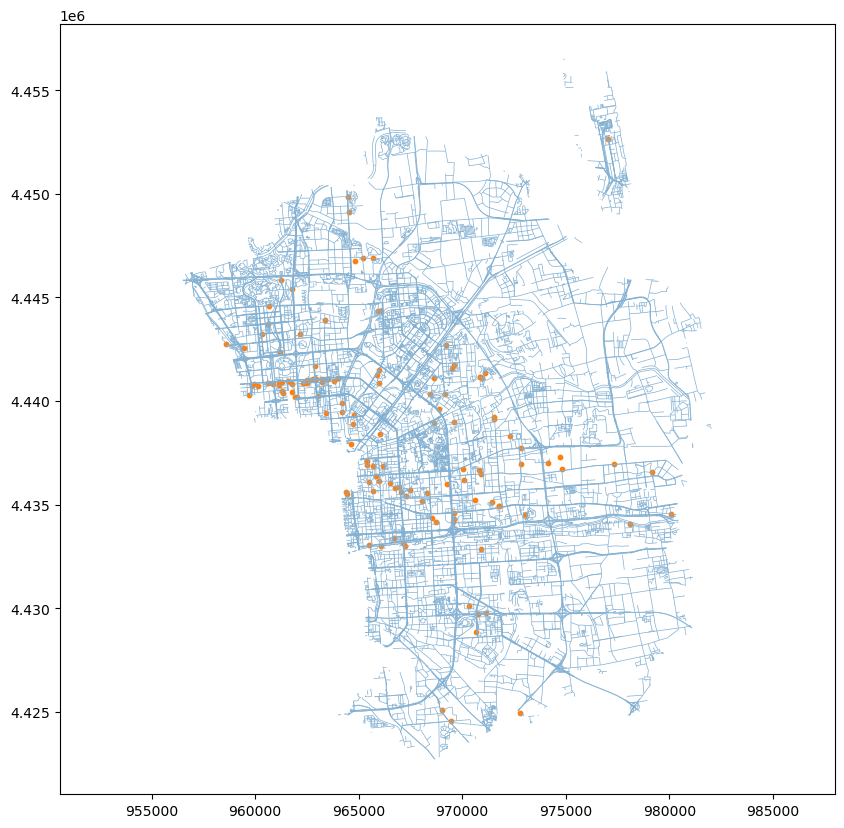

In [6]:
fig, ax = plt.subplots(figsize=(10, 10))
road_net.plot(ax=ax, color='#82b0d2', edgecolor='gray', linewidth=0.5)
ax.scatter(poi['X'], poi['Y'], c='C1', s=10, label = 'Emergency Location')
ax.axis('equal')

In [7]:
loc = np.array(poi[['POINT_X', 'POINT_Y']])
p = 20
real_radius = 2000
dist = np.sum((loc[:, np.newaxis, :] - loc[np.newaxis, :, :]) ** 2, axis=-1) ** 0.5
np_dist = np.array(dist)

In [8]:
x, y, obj = gurobi_solver_MCLP(loc, p, np_dist, real_radius)
solutions = [id for id, key in enumerate(x) if key == 1]
print(f"The avg objective of MCLP samples is: {obj}")

The avg objective of MCLP samples is: 128.0


In [9]:
def plot_result(ls, opt_sites, radius):
    '''
    Plot the result
    Input:
        points: input points, Numpy array in shape of [N,2]
        opt_sites: locations K optimal sites, Pandas DataFrame
        radius: the radius of circle
    '''
    fig, ax = plt.subplots(figsize=(12, 12))
    road_net.plot(ax=ax, color='#82b0d2', edgecolor='gray', linewidth=0.5)
    # ls.plot(ax=ax, column=ls['speed_pct_freeflow_rev'], k=5, markersize=5, cmap='Blues', label='Demand Points')
    legend_plot_flag = {'current': False, 'selected': False}
    ax.scatter(ls['POINT_X'], ls['POINT_Y'], c='#fa7f6f', s=20, label = 'Billboards')

    for cnt, site in opt_sites.iterrows():
        if 'current' in opt_sites.columns and site['current'] == True:  #ncurrent
            if legend_plot_flag['current'] == False:
                ax.scatter(site['POINT_X'], site['POINT_Y'], c='red', marker='+', s=10, label='Current Billboards')
                circlelabel = 'Service Range for Current Billboards'
                legend_plot_flag['current'] = True
            ax.scatter(site['POINT_X'], site['POINT_Y'], c='red', marker='+', s=100)
            #             circle = plt.Circle(site[['POINT_X','POINT_Y']], radius, color='red', fill=False, lw=2, label = circlelabel)
            circle = plt.Circle(site[['POINT_X', 'POINT_Y']], radius, color='red', fill=False, lw=2)

            ax.add_artist(circle)
        else:
            if legend_plot_flag['selected'] == False:
                ax.scatter(site['POINT_X'], site['POINT_Y'], c='b', marker='+', s=10,
                           label='Optimized Selected Billboards')
                circlelabel = 'Service Range for Optimized Selected Billboards'
                legend_plot_flag['selected'] = True
            ax.scatter(site['POINT_X'], site['POINT_Y'], c='b', marker='+', s=100)
            #             circle = plt.Circle(site[['POINT_X','POINT_Y']], radius, color='C1', fill=False, lw=2, label = circlelabel)
            circle = plt.Circle(site[['POINT_X', 'POINT_Y']], radius, color='#8983bf', fill=False, lw=2)
            ax.add_artist(circle)
    #
    ax.axis('equal')
    # ax.tick_params(axis='both', left=False, top=False, right=False,
    #                bottom=False, labelleft=False, labeltop=False,
    #                labelright=False, labelbottom=False)
    # title = 'Selected ' + str(len(opt_sites)) + ' Sites that Serve ' + str(radius) + ' m' + 'by DRL'
#     ax.set_title("Gurobi", fontsize=20)
#     render_scale_bar(ax=ax, x=0.05, y=0.05)
#     render_north_arrow(ax=ax, x=0.95, y=0.95, size=0.01, ratio=0.7)
    # ax.legend(loc='lower right', markerscale=2)
    return ax

In [10]:
def render_north_arrow(ax, x, y, size, ratio = 1):
    path = [(0, 1), (-ratio, -1), (0, -0.5), (ratio, -1), (0, 1)]
    path = [(i[0] * size + x, i[1] * size + y) for i in path]
    arrow = plt.Polygon(path, color='black', transform=ax.transAxes)
    ax.add_patch(arrow)
    ax.text(x, y-size*2, s = 'N', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    
def render_scale_bar(ax, x, y, segments=2, height=0.01, seg_length=2000, unit='m', linewidth=1.):
    unit_scale_factor = {
        'm': 1,
        'km': 1000,
        'meters': 1,
        'kilometers': 1000,
        'miles': 1609.34,
        'mi': 1609.34,
        'ft': 0.3,
        }
    x_lim = ax.get_xlim()
    y_lim = ax.get_ylim()

    # how much percent does one unit takes on the x axis
    x_per_unit = 1. / (x_lim[1] - x_lim[0])
    y_per_unit = 1. / (y_lim[1] - y_lim[0])

    # base for ticks (0, 1)
    x_base = [x + seg_length * unit_scale_factor[unit] * x_per_unit * i for i in range(0, segments + 1)]
    ax.axhline(y_lim[0] + y / y_per_unit, x_base[0], x_base[-1], c='black')
    y_base = [y, y + height]
    for i in range(segments + 1):
        ax.axvline(x_lim[0] + x_base[i] / x_per_unit, y, y + height, c='black')
        xy = (x_lim[0] + x_base[i] / x_per_unit, y_lim[0] + (y - 0.015) / y_per_unit)  # data_coords
        ax.text(xy[0], xy[1], s='{}'.format(int(seg_length * i)), horizontalalignment='center', verticalalignment='center')
    ax.text(x_lim[0] + (x_base[-1] + 0.02) / x_per_unit, y_lim[0] + (y - 0.015) / y_per_unit,
            s=unit, horizontalalignment='left',
            verticalalignment='center')

<AxesSubplot:>

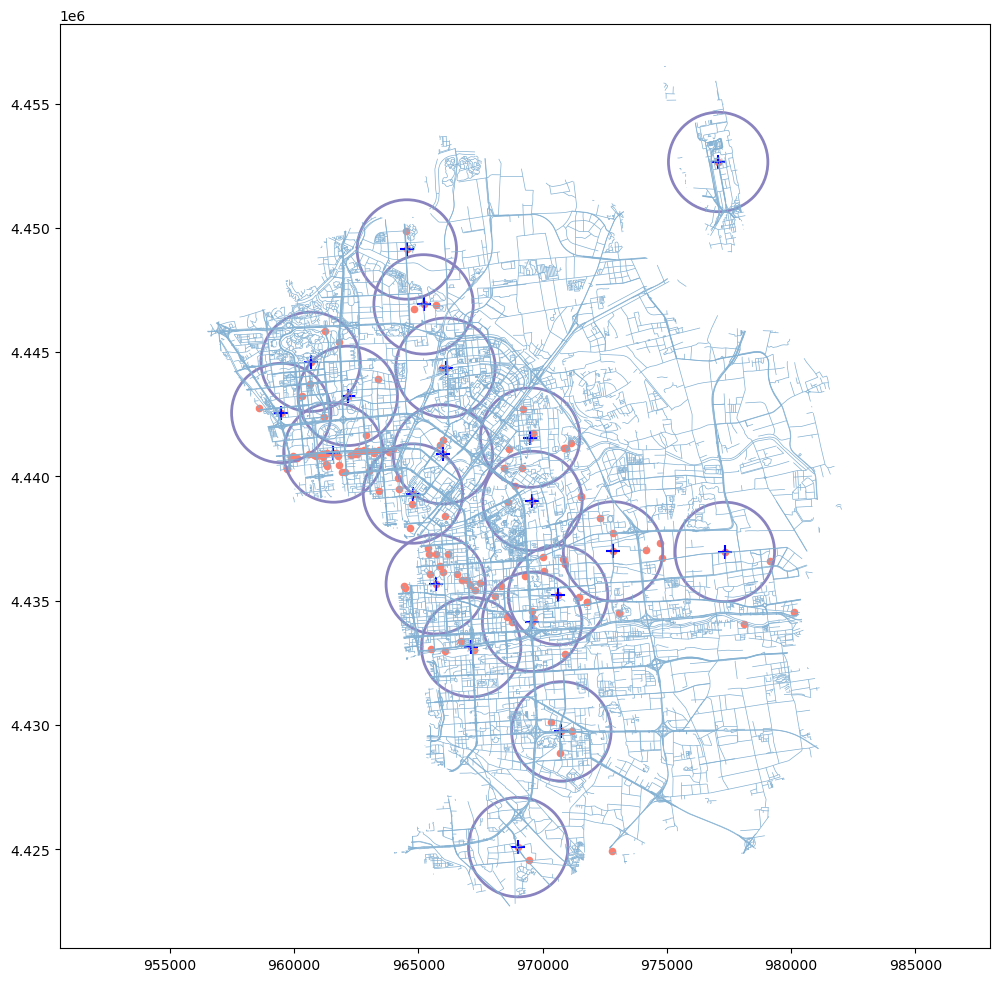

In [11]:
opt_sites = poi.iloc[solutions]
plot_result(poi,opt_sites,2000)